In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

In [9]:
# load data
%run new_preprocess.ipynb
def split(X, y, test_size, val_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size/(1-test_size), random_state=1)

    return X_train, y_train, X_val, y_val, X_test, y_test

df = pd.read_csv('cleaned_extracted_data.csv')
df = df.drop('Unnamed: 0', axis=1)
X = df.drop('shares', axis=1)
y = df['shares']
print(f"X shape: {X.shape}", f"y shape: {y.shape}")
print(X.head())
X_train, y_train, X_val, y_val, X_test, y_test = split(X, y, 0.1, 0.3)


X shape: (12600, 30) y shape: (12600,)
   n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0        0.947707         -0.439662         0.428161          0.002998   
1       -0.684112         -0.329189        -0.117285         -0.230132   
2       -0.684112         -0.488761        -0.049791         -0.040442   
3       -0.140172          0.315234        -1.027334         -0.225009   
4        1.491646         -0.200305        -0.756442          0.313212   

   n_non_stop_unique_tokens  num_hrefs  num_imgs  num_videos  \
0                 -0.418972  -0.324104 -0.313340         0.0   
1                 -0.319133  -0.584280 -0.313340         0.0   
2                 -0.568731  -0.584280 -0.313340         0.0   
3                  0.296542  -0.454192  0.058349         0.0   
4                 -0.244254  -0.844455 -0.313340         0.0   

   average_token_length  weekday_is_monday  ...  global_rate_negative_words  \
0             -0.186062                  1  ...     

In [10]:
# load data without preprocessing
from ucimlrepo import fetch_ucirepo

# fetch dataset
online_news_popularity = fetch_ucirepo(id=332)

# data (as pandas dataframes)
X_raw = online_news_popularity.data.features
y_raw = online_news_popularity.data.targets

# metadata
print(online_news_popularity.metadata)
# variable information
print(online_news_popularity.variables)


{'uci_id': 332, 'name': 'Online News Popularity', 'repository_url': 'https://archive.ics.uci.edu/dataset/332/online+news+popularity', 'data_url': 'https://archive.ics.uci.edu/static/public/332/data.csv', 'abstract': 'This dataset summarizes a heterogeneous set of features about articles published by Mashable in a period of two years. The goal is to predict the number of shares in social networks (popularity).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 39797, 'num_features': 58, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': [' shares'], 'index_col': ['url'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Thu Feb 15 2024', 'dataset_doi': '10.24432/C5NS3V', 'creators': ['Kelwin Fernandes', 'Pedro Vinagre', 'Paulo Cortez', 'Pedro Sernadela'], 'intro_paper': {'title': 'A Proactive Intelligent Decision Support System for Predicti

In [6]:
# split unpreprocessed data into training, validation and test sets
X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw = split(X_raw, y_raw,test_size=0.2, val_size=0.3)

In [11]:
# create a random forest regressor model
rf = RandomForestRegressor(n_estimators=72, random_state=42) # n_estimators is the number of trees in the forest
rf.fit(X_train, y_train)
# create a random forest regressor model
rf_raw = RandomForestRegressor(n_estimators=72, random_state=42) # n_estimators is the number of trees in the forest
rf_raw.fit(X_train_raw, y_train_raw)

C:\Users\rodcs\.conda\envs\data_science_tests\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(n_estimators=72, random_state=42)

In [70]:
# Caclulate performance using the validation set
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_pred = rf.predict(X_val)
print(y_pred)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
score = rf.score(X_val, y_val)
print(f'Mean Squared Error for normalised data: {mse}')
print(f'Mean Absolute Error for normalised data: {mae}')
print(f'R^2 score for normalised data: {score}')

y_pred_raw = rf_raw.predict(X_val_raw)
mse_raw = mean_squared_error(y_val_raw, y_pred_raw)
mae_raw = mean_absolute_error(y_val_raw, y_pred_raw)
score_raw = rf_raw.score(X_val_raw, y_val_raw)

print(f'Mean Squared Error for raw data: {mse_raw}')
print(f'Mean Absolute Error for raw data: {mae_raw}')
print(f'R^2 score for raw data: {score_raw}')



[-0.04202031  0.00647183 -0.07637566 ...  0.21901346 -0.09771763
 -0.09632587]
Mean Squared Error for normalised data: 0.9328387286124296
Mean Absolute Error for normalised data: 0.2483369377429987
R^2 score for normalised data: -0.054696284553577446
Mean Squared Error for raw data: 160002443.72788826
Mean Absolute Error for raw data: 3513.2590416736734
R^2 score for raw data: -0.03922504724847964


In [23]:
# tune hyperparameters
def grid_search_tunning(n_estimators, criterion, max_depth, min_samples_split, X_train, y_train, X_val, y_val):
    """
    This function performs a grid search to find the best hyperparameters for a random forest regressor model.
    params:
    n_estimators: list of integers, the number of trees in the forest
    criterion: list of strings, the function to measure the quality of a split
    max_depth: list of integers, the maximum depth of the tree
    min_samples_split: list of integers, the minimum number of samples required to split an internal node
    X_train: pandas dataframe, the training data
    y_train: pandas series, the training labels
    X_val: pandas dataframe, the validation data
    y_val: pandas series, the validation labels
    """
    scores = []
    scores_train = []
    mse_list = []
    mse_train_list = []
    max_depths = []
    min_samples_splits = []
    min_mse = np.inf
    min_mse_train = np.inf
    max_score = -1
    max_score_train = 0
    for c in criterion:
            for d in max_depth:
                for s in min_samples_split:
                    rf = RandomForestRegressor(n_estimators=n_estimators, criterion=c, max_depth=d, min_samples_split=s, random_state=42)
                    rf.fit(X_train, y_train)
                    # calculate performance using the validation set
                    # let's start with testing data
                    train_score = rf.score(X_train, y_train)
                    mse_train = mean_squared_error(y_train, rf.predict(X_train))

                    # calculate performance using the validation set
                    score = rf.score(X_val, y_val)
                    mse = mean_squared_error(y_val, rf.predict(X_val))
                    min_samples_splits.append(s)
                    max_depths.append(d)

                    scores.append(score)
                    scores_train.append(train_score)

                    mse_list.append(mse)
                    mse_train_list.append(mse_train)


                    if mse < min_mse:
                        best_mse = mse
                        best_params_mse = {'n_estimators': n_estimators, 'criterion': c, 'max_depth': d, 'min_samples_split': s}
                    if mse_train < min_mse_train:
                        min_mse_train = mse_train
                        best_params_mse_train = {'n_estimators': n_estimators, 'criterion': c, 'max_depth': d, 'min_samples_split': s}
                    if score > max_score:
                        max_score = score
                        best_params_score = {'n_estimators': n_estimators, 'criterion': c, 'max_depth': d, 'min_samples_split': s}
                    if train_score > max_score_train:
                        max_score_train = train_score
                        best_params_score_train = {'n_estimators': n_estimators, 'criterion': c, 'max_depth': d, 'min_samples_split': s}


    print(f"Best Parameters for Min MSE: {best_params_mse}")
    print(f"Best Parameters for Max Score: {best_params_score}")
    print(f"Best Parameters for Min MSE Train: {best_params_mse_train}")
    print(f"Best parameters for max score train: {best_params_score_train}")
    return scores, scores_train, mse_list, mse_train_list, max_depths, min_samples_splits, best_params_mse, best_params_score, best_params_mse_train, best_params_score_train


In [50]:
scores, scores_train, mse_list, mse_train_list, max_depths, min_samples_splits, best_params_mse, best_params_score, best_params_mse_train, best_params_score_train = grid_search_tunning(n_estimators=100,
                    criterion=["squared_error", "friedman_mse"],
                    max_depth=[1, 3, 5, 7, 9, 11, 13, 15, 17, 20],
                    min_samples_split=[2, 5, 10, 18, 26, 34, 42, 50],
                    X_train=X_train, y_train=y_train,
                    X_val=X_val,
                    y_val=y_val)

Best Parameters for Min MSE: {'n_estimators': 100, 'criterion': 'friedman_mse', 'max_depth': 20, 'min_samples_split': 50}
Best Parameters for Max Score: {'n_estimators': 100, 'criterion': 'squared_error', 'max_depth': 1, 'min_samples_split': 2}
Best Parameters for Min MSE Train: {'n_estimators': 100, 'criterion': 'friedman_mse', 'max_depth': 20, 'min_samples_split': 2}
Best parameters for max score train: {'n_estimators': 100, 'criterion': 'friedman_mse', 'max_depth': 20, 'min_samples_split': 2}


In [72]:
print(f"Best score for training: {max(scores_train)}")
print(f"Best score for validation: {max(scores)}")
print(f"Best MSE for training: {min(mse_train_list)}")
print(f"Best MSE for validation: {min(mse_list)}")

Best score for training: 0.8135431685904324
Best score for validation: -0.0018468380054732503
Best MSE for training: 0.12423053909939195
Best MSE for validation: 0.8860954042565735


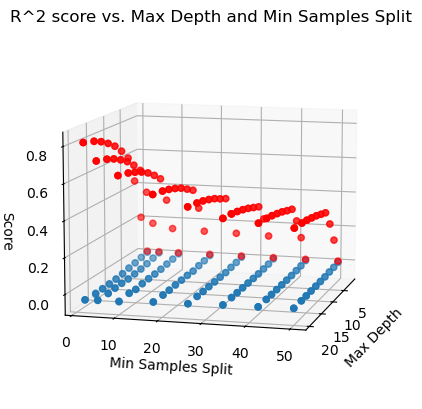

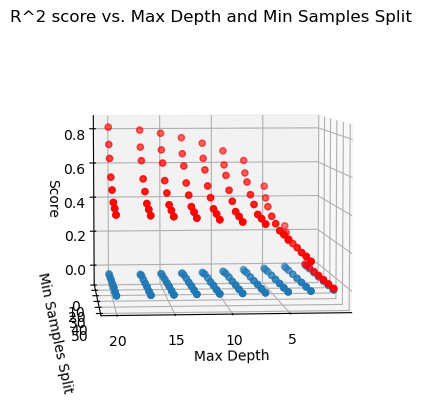

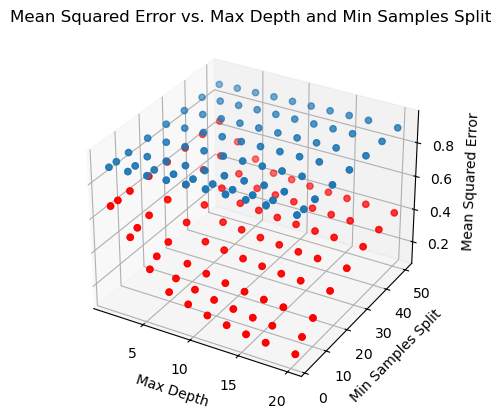

In [69]:
# plot a 3d scatter plot
import matplotlib.pyplot as plt
# plot a 3d scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(max_depths, min_samples_splits, scores)
ax.set_xlabel('Max Depth')
ax.set_ylabel('Min Samples Split')
ax.set_zlabel('Score')
# add another set of scores. plot in a different color
new_scores = scores_train
ax.scatter(max_depths, min_samples_splits, new_scores, c='r')
# name the plot
plt.title("R^2 score vs. Max Depth and Min Samples Split")
ax.view_init(10, 15)
plt.show()

#show a new perspective, rotated 90 degrees
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(max_depths, min_samples_splits, scores)
ax.set_xlabel('Max Depth')
ax.set_ylabel('Min Samples Split')
ax.set_zlabel('Score')
# add another set of scores. plot in a different color
new_scores = scores_train
ax.scatter(max_depths, min_samples_splits, new_scores, c='r', label='Train Scores')
# name the plot
plt.title("R^2 score vs. Max Depth and Min Samples Split")
#
ax.view_init(5, 85)
plt.show()

# plot a 3d scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(max_depths, min_samples_splits, mse_list)
ax.set_xlabel('Max Depth')
ax.set_ylabel('Min Samples Split')
ax.set_zlabel('Mean Squared Error')
new_mse_list = mse_train_list
ax.scatter(max_depths, min_samples_splits, new_mse_list, c='r')
# name the plot
plt.title("Mean Squared Error vs. Max Depth and Min Samples Split")
plt.show()


In [64]:
# Nowe let's use the best parameters to train the model
bestest_rf = RandomForestRegressor(n_estimators=72, criterion=best_params_score['criterion'], max_depth=best_params_score['max_depth'], min_samples_split=best_params_score['min_samples_split'], random_state=42)

In [65]:
bestest_rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=1, n_estimators=72, random_state=42)

In [67]:
test_score = bestest_rf.score(X_test, y_test)
test_mse = mean_squared_error(y_test, bestest_rf.predict(X_test))
print(f"Test score: {test_score}")
print(f"Test MSE: {test_mse}")

Test score: -0.0011977917497043578
Test MSE: 3.3513142582815245


In [68]:
import pickle
# pickle the model
with open('bestest_rf.pkl', 'wb') as f:
    pickle.dump(bestest_rf, f)


In [71]:
best_params_score['max_depth']

1